In [1]:
# import packages
import numpy as np 
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import arviz as az
import pymc3 as pm
#设置seed
np.random.seed(123)

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [4]:
data = pd.read_csv("./data/rt_tidy.csv")

In [5]:
# create the new column that uses centralized rating
data['ratingcen'] = (data['rating'] - 5).abs() + 1
#transform country to region
region_mapping = {
    "KE": "Africa",
    "NG": "Africa",
    "ZA": "Africa",
    "CN": "East_Southeast_Asia",
    "IN": "East_Southeast_Asia",
    "MY": "East_Southeast_Asia",
    "TW": "East_Southeast_Asia",
    "TH": "East_Southeast_Asia",
    "AU": "Australia_New_Zealand",
    "NZ": "Australia_New_Zealand",
    "SV": "Central_America_Mexico",
    "MX": "Central_America_Mexico",
    "HU": "Eastern_Europe",
    "LT": "Eastern_Europe",
    "PL": "Eastern_Europe",
    "RU": "Eastern_Europe",
    "RS": "Eastern_Europe",
    "SK": "Eastern_Europe",
    "IR": "Middle_East",
    "IL": 	"Middle_East",
    'TR': 'Middle_East',
     'CA': 'United_States_Canada',
     'US': 'United_States_Canada',
     'DK': 'Scandinavia',
     'FI': 'Scandinavia',
     'NO': 'Scandinavia',
     'SE': 'Scandinavia',
     'AR': 'South_America',
     'BR': 'South_America',
     'CL': 'South_America',
     'CO': 'South_America',
     'EC': 'South_America',
     'GB-ENG': 'United_Kingdom',
     'GB-SCT': 'United_Kingdom',
     'GB-WLS': 'United_Kingdom',
     'AT': 	"Western_Europe",
     'BE': 	"Western_Europe",
     'FR': 	"Western_Europe",
     'DE': 	"Western_Europe",
     'GR': 	"Western_Europe",
     'IT': 	"Western_Europe",
     'NL': 	"Western_Europe",
     'PT': 	"Western_Europe",
     'ES': 	"Western_Europe",
     'CH': 	"Western_Europe"
}
data["region"] = data["country"].map(region_mapping)
#get rating equal 2 and 5
data2 = data[(data['ratingcen'] == 2) | (data['ratingcen'] == 5)]
#get trait unhappy
data2 = data2[data2['trait'] == 'unhappy']
#
data2['ratingcen'] = np.where(data2['ratingcen'] == 2, 0, 1)
data2.head(10)

,Unnamed: 0,X.1,language,user_id,trait,stim_id,order,rt,rating,country,...,block,X,Race,Gender,Age,ethnicity.y,gender,log_rt,ratingcen,region
17,18,270683,ENG,4405,unhappy,BM-210,70,1182,6,US,...,2,53,B,M,29.225806,black,male,7.074963,0,United_States_Canada
34,35,137070,ENG,2295,unhappy,LM-214,23,1854,4,NL,...,1,79,L,M,27.500000,latinx,male,7.525101,0,Western_Europe
48,49,766900,SLO,12297,unhappy,BM-250,86,3030,1,SK,...,2,59,B,M,34.931034,black,male,8.016318,1,Eastern_Europe
92,93,498058,ENG,7858,unhappy,LM-217,74,2399,4,HK,...,1,80,L,M,33.440000,latinx,male,7.782807,0,NaN
183,184,414938,EL,6591,unhappy,AM-225,67,1861,6,GR,...,2,23,A,M,24.680000,asian,male,7.528869,0,Western_Europe
185,186,492275,ENG,7777,unhappy,WF-211,35,598,4,CA,...,2,100,W,F,21.551724,white,female,6.393591,0,United_States_Canada
195,196,177441,ENG,2964,unhappy,WF-210,60,5000,9,AE,...,1,99,W,F,27.384615,white,female,8.517193,1,NaN
199,200,884517,SPA,14286,unhappy,WM-003,9,6551,6,EC,...,1,106,W,M,23.345238,white,male,8.787373,0,South_America
233,234,406951,ENG,6490,unhappy,BF-244,70,1647,6,CA,...,1,43,B,F,29.107143,black,female,7.406711,0,United_States_Canada
234,235,300506,ENG,4935,unhappy,LF-213,14,1270,4,US,...,1,66,L,F,25.800000,latinx,female,7.146772,0,United_States_Canada


In [6]:
region_idxs, region = pd.factorize(data2.region)
stim_idxs, stim_id = pd.factorize(data2.stim_id)

coords3 = {
    "region": region,
    "region_id": np.arange(len(region_idxs)),
    'stim_id': stim_id,
    "stim_idx": np.arange(len(stim_idxs)),
}

In [7]:
with pm.Model(coords = coords3) as model_Bernoulli2:

    # 定义先验分布
    #region_sd = pm.HalfNormal('region_sd', sd = 50)    #region截距的先验
    #stim_id_sd = pm.HalfNormal('stim_id_sd', sd = 50)  #stim截距的先验

    # 定义分层的随机效应
    region_effects = pm.Normal('region_effects', mu=0, sd=50, dims = "region")      #region效应
    stim_id_effects = pm.Normal('stim_id_effects', mu=0, sd=50, dims = "stim_id")  #stim效应

    #rt的先验分布
    rt_nu = pm.HalfNormal('rt_nu', 30)
    rt = pm.ExGaussian('rt', mu=1700, sigma=1000, nu = rt_nu, observed=data2.rt)
    
    region_idx = pm.Data("region_idx", region_idxs, dims="region_id")
    stim_idxx = pm.Data("stim_idxx", stim_idxs, dims="stim_idx")
    # 计算预测的响应时间
    rating_p = pm.math.sigmoid(stim_id_effects[stim_idxx] + stim_id_effects[region_idx] + rt*region_effects[region_idx])
    # 定义观测变量
    rating_y = pm.Bernoulli('rating_y', p=rating_p, observed = data2.ratingcen)

d:\Anaconda\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log1p
  variables = ufunc(*ufunc_args, **ufunc_kwargs)


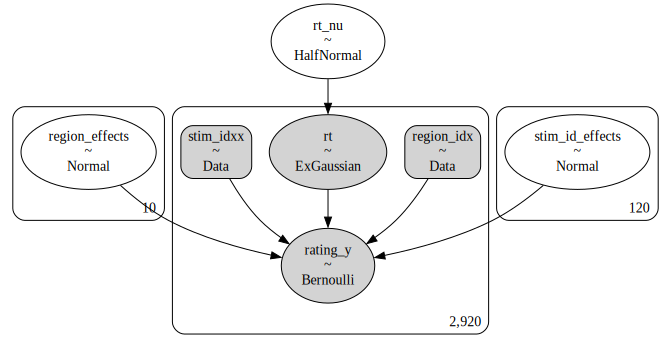

In [8]:
pm.model_to_graphviz(model_Bernoulli2)

In [9]:
#MCMC sampling
with model_Bernoulli2:
    trace_Bernoulli2 = pm.sample(draws = 2000, tune= 1000, target_accept=0.9, chains=2, cores= 2,return_inferencedata=True,init="adapt_diag")

WARNING (theano.tensor.opt): Optimization Warning: The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
d:\Anaconda\lib\site-packages\theano\scalar\basic.py:3023: RuntimeWarning: divide by zero encountered in log1p
  return np.log1p(x)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
d:\Anaconda\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
d:\Anaconda\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
d:\Anaconda\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in true_divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
d:\Anaconda\lib\site-packages\theano\scalar\basic.py:2851: RuntimeWarning: divide by zero encountered in true_divide
  return np.float32(1.0

In [ ]:
with model_Bernoulli2:
    prior_checks = pm.sample_prior_predictive(samples=100)

In [ ]:
az.plot_density(
    {'rt':prior_checks['rt']}
    )
plt.show()

In [ ]:
az.plot_density(
    {'region_effects':prior_checks['region_effects']}
    )
plt.show()

In [ ]:
az.plot_density(
    {'stim_id_effects':prior_checks['stim_id_effects']}
    )
plt.show()

In [ ]:
az.plot_density(
    {'rating_y':prior_checks['rating_y']}
    )
plt.show()

In [ ]:
az.plot_trace(trace_Bernoulli2, var_names=['region_effects','stim_id_effects'])
plt.show()

In [ ]:
with model_Bernoulli2:
    ppc_y = pm.sample_posterior_predictive(trace_Bernoulli2.posterior) 
az.concat(trace_Bernoulli2, az.from_pymc3(posterior_predictive=ppc_y), inplace=True)

In [ ]:
az.summary(trace_Bernoulli2, var_names=['region_effects'])

In [ ]:
az.plot_ppc(trace_Bernoulli2)
plt.show()

In [ ]:
az.plot_forest(trace_Bernoulli2, var_names=['region_effects'], combined=True)

In [ ]:
region_effects_samples2 = trace_Bernoulli2.posterior["region_effects"].values
total_region_effects = np.sum(region_effects_samples, axis=(0, 1))
az.summary(total_region_effects)